In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(
    "../../data/plasmodium_malaria_subsampled_encoded_28_train.csv",
    converters={"Encoded_Bit_Vector": lambda x: np.fromstring(x[1:-1], sep=", ")}
)
df.head()

,SMILES,binary,Encoded_Bit_Vector
0,COc1ccc(N=c2[nH]cnc3ccc(NC(=S)Nc4cccc5ccccc45)...,1,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."
1,Clc1ccc2c(=NCCCN=c3[nH]c(N4CCCCC4)nc(=NC4CCCCC...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
2,CC(C)N=c1cc(-c2c[nH]nc2C2CCN(C(=O)C3CCC3)C2)cc...,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,COc1cc2c(c(O)c1OC)OCC(c1cc(O)c(OC)c(OC)c1O)C2O,0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
4,CCCN(CCC)c1ccc2nc3ccc(N(CCC)CCC)cc3[o+]c2c1,1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ..."


In [3]:
fplen = 1024


def smiles2ecfp(smi):
    fpgen = AllChem.GetMorganGenerator(radius=3, fpSize=fplen)
    m1 = Chem.MolFromSmiles(smi)
    return fpgen.GetFingerprintAsNumPy(m1)


df["ecfp"] = df.apply(lambda row: smiles2ecfp(row["SMILES"]), axis=1)

### Identifying highly correlated bits

In [4]:
cols = [f'Bit_{n}' for n in range(len(df['Encoded_Bit_Vector'][0]))]
data = dict(zip(range(len(df['Encoded_Bit_Vector'])), df['Encoded_Bit_Vector']))
fps = pd.DataFrame.from_dict(data, orient='index', columns=cols)
print(fps.head())

   Bit_0  Bit_1  Bit_2  Bit_3  Bit_4  Bit_5  Bit_6  Bit_7  Bit_8  Bit_9  ...  \
0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    1.0    1.0    0.0  ...   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0  ...   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
3    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0  ...   
4    0.0    0.0    1.0    0.0    0.0    0.0    1.0    0.0    1.0    1.0  ...   

   Bit_18  Bit_19  Bit_20  Bit_21  Bit_22  Bit_23  Bit_24  Bit_25  Bit_26  \
0     0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     1.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
2     0.0     1.0     0.0     0.0     0.0     0.0     1.0     1.0     1.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   Bit_27  
0     1.0  
1     0.0  
2     0.0  
3     1.

In [12]:
max_threshold = 1
min_threshold = 0

threshold = max_threshold
high_corr = {}
corr = fps.corr(numeric_only=True).abs()
while threshold > min_threshold:
    key = [(corr.index[x], corr.columns[y]) for x, y in zip(*(np.where(corr > threshold))) if x != y and x < y]
    if len(key) > 0:
        high_corr[threshold] = key
        
    threshold -= 0.01
    # TODO: larger groups & heatmap
print(high_corr)
print(threshold)


{0.28999999999999937: [('Bit_12', 'Bit_25')], 0.27999999999999936: [('Bit_0', 'Bit_24'), ('Bit_12', 'Bit_25')], 0.26999999999999935: [('Bit_0', 'Bit_24'), ('Bit_12', 'Bit_25')], 0.25999999999999934: [('Bit_0', 'Bit_24'), ('Bit_12', 'Bit_25')], 0.24999999999999933: [('Bit_0', 'Bit_24'), ('Bit_4', 'Bit_26'), ('Bit_11', 'Bit_25'), ('Bit_12', 'Bit_25'), ('Bit_19', 'Bit_20')], 0.23999999999999932: [('Bit_0', 'Bit_24'), ('Bit_4', 'Bit_26'), ('Bit_6', 'Bit_25'), ('Bit_11', 'Bit_25'), ('Bit_12', 'Bit_25'), ('Bit_19', 'Bit_20')], 0.22999999999999932: [('Bit_0', 'Bit_24'), ('Bit_4', 'Bit_26'), ('Bit_6', 'Bit_25'), ('Bit_10', 'Bit_11'), ('Bit_11', 'Bit_25'), ('Bit_12', 'Bit_25'), ('Bit_19', 'Bit_20')], 0.2199999999999993: [('Bit_0', 'Bit_24'), ('Bit_4', 'Bit_26'), ('Bit_6', 'Bit_25'), ('Bit_10', 'Bit_11'), ('Bit_11', 'Bit_25'), ('Bit_12', 'Bit_25'), ('Bit_19', 'Bit_20')], 0.2099999999999993: [('Bit_0', 'Bit_24'), ('Bit_4', 'Bit_26'), ('Bit_6', 'Bit_25'), ('Bit_10', 'Bit_11'), ('Bit_11', 'Bit_25')

<Axes: >

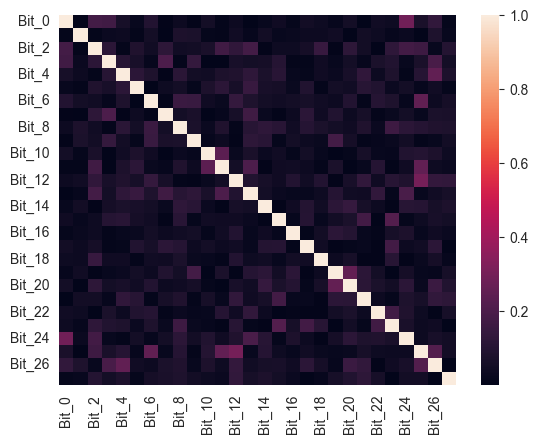

In [9]:
sns.heatmap(corr)